

 # 【分析レポート】過去は未来を語るか？AAPL株価予測モデル対決

 ## 1. 分析の目的

 金融市場における永遠のテーマ、「過去のデータから未来の株価を予測することは可能か？」という問いに、データサイエンスのアプローチで挑む。

 この分析では、Apple Inc. (AAPL) の過去5年間の株価データを対象とし、思想の異なる2つの代表的な予測モデルを構築・比較する。
 1.  **ARIMAモデル:** データの内部構造（自己相関など）を重視する、伝統的な統計的時系列モデル。
 2.  **Prophetモデル:** トレンドや季節性といったパターンを重視する、Facebookが開発した現代的な機械学習系モデル。

 最終的に、どちらのモデルがより現実に近い予測を立てられたかを客観的な指標で評価し、株価予測の可能性と限界について考察する。

 ## 2. 分析の結論（エグゼクティブ・サマリー）

 分析の結果、過去1年間のテスト期間においては、**ARIMA(0,1,0)モデル、すなわち「ランダムウォーク・モデル」が、Prophetモデルよりも予測誤差が著しく小さく、数値上は圧倒的に優れたパフォーマンスを示した。**

 これは、株価の動きが「昨日の価格が、明日の価格の最も良い推定量である」という、**効率的市場仮説に非常に近い**性質を持つことを強く示唆している。Prophetが抽出しようとした過去の季節性パターンは、未来の予測においてはノイズとなり、かえって精度を悪化させた。

 このことから、**単純な時系列データのみを用いた精密な株価予測は極めて困難**であり、モデルの予測能力の限界を認識することが重要であると結論づける。

In [ ]:
#%% データ準備とライブラリのインポート

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Prophetはfbprophetまたはprophetとしてインポートされる場合があります
try:
    from prophet import Prophet
except ImportError:
    from fbprophet import Prophet
import japanize_matplotlib  # 日本語プロット対応
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
#%% データ取得

# Appleの株価（AAPL）を過去5年分取得
symbol = "AAPL"
data = yf.download(symbol, period="5y", group_by='ticker')
# カラム構造を確認
print(data.columns)
# MultiIndexの場合も考慮して調整後終値または終値を取得
ts_data = None
if ("Adj Close" in data.columns):
    ts_data = data["Adj Close"]
elif (symbol, "Adj Close") in data.columns:
    ts_data = data[(symbol, "Adj Close")]
elif (symbol, "Close") in data.columns:
    ts_data = data[(symbol, "Close")]
elif "Close" in data.columns:
    ts_data = data["Close"]
else:
    print("利用可能なカラム:", data.columns)
    raise KeyError("'Adj Close'や'Close'カラムが見つかりません")

<ipython-input-26-dcf501cf18b2>:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, period="5y", group_by='ticker')
[*********************100%***********************]  1 of 1 completed

MultiIndex([('AAPL',   'Open'),
            ('AAPL',   'High'),
            ('AAPL',    'Low'),
            ('AAPL',  'Close'),
            ('AAPL', 'Volume')],
           names=['Ticker', 'Price'])




 ## 3. 探索的データ分析(EDA) - データの"声"を聞く

 予測モデルを構築する前に、まずデータそのものが持つ特性を理解することが不可欠である。ここでは、Appleの株価データの構造を視覚的に分解し、モデル構築のための重要なヒントを探る。

 ### 3-1. トレンドの確認

 まずは、株価の時系列グラフをプロットする。グラフは明確な右肩上がりの**トレンド**を持っており、このような時間と共に平均が変動するデータを**「非定常時系列」**と呼ぶ。多くの統計モデルはデータが定常（平均や分散が一定）であることを前提とするため、このトレンドを除去する処理が必要となる。

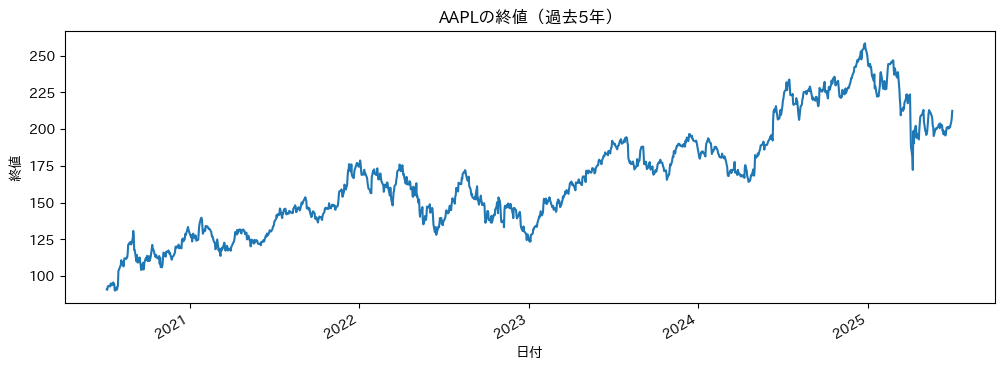

In [ ]:
#%% トレンドの確認

plt.figure(figsize=(12, 4))
ts_data.plot()
plt.title("AAPLの終値（過去5年）")
plt.xlabel("日付")
plt.ylabel("終値")
plt.show()
# ヒント: 右肩上がりのトレンドが見られ、非定常性が疑われる



 ### 3-2. 定常性への変換（階差の計算）

 トレンドを除去する最も一般的な方法は**「階差」**を取ることである。これは、今日の値から昨日の値を引く操作に相当し、日々の「変化量」のデータに変換する。

 以下のグラフが示すように、1階差分を取ることで、元のデータが持っていた右肩上がりのトレンドは綺麗になくなり、平均0の周りをランダムに変動する**「定常時系列」**に近いデータに変換できた。このことから、ARIMAモデルのパラメータ`d`（階差の次数）は`1`が妥当であると判断できる。

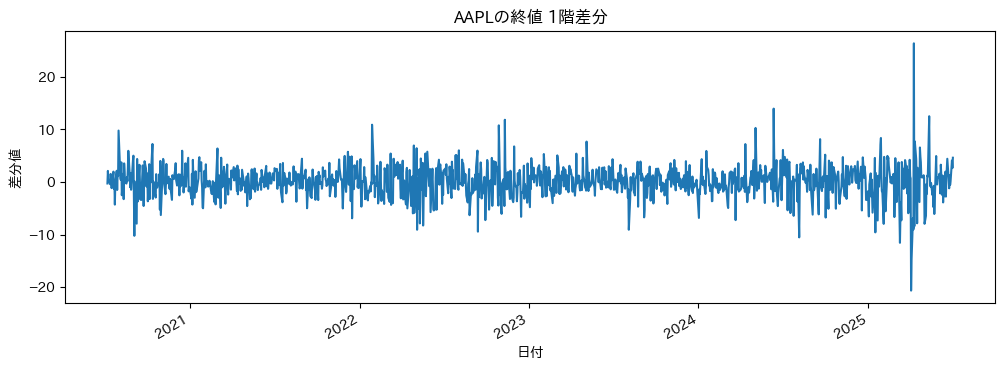

In [ ]:
#%% d（階差）の決定

# 1階差分を計算
ts_diff = ts_data.diff().dropna()
plt.figure(figsize=(12, 4))
ts_diff.plot()
plt.title("AAPLの終値 1階差分")
plt.xlabel("日付")
plt.ylabel("差分値")
plt.show()
# ヒント: トレンドが除去され、平均0の周りで変動する定常性に近いデータとなった
# → ARIMAモデルのパラメータdは1が妥当だろう



 ### 3-3. データの"記憶"を探る (ACFとPACF)

 次に、差分後のデータに、まだ予測の手がかりとなるような「記憶（自己相関）」が残っているかを調べる。そのためのツールがACFとPACFグラフである。

 - **ACF (自己相関):** 今日の値と、N日前の値との単純な相関。
 - **PACF (偏自己相関):** N日前の値が、間に存在する全ての影響を取り除いた上で、今日の値に与える直接的な相関。

 **【グラフの読み解きとパラメータ選択の根拠】**
 ACFとPACFのグラフを見ると、**ほぼ全てのラグ（横軸の点）が青い信頼区間の内側に収まっており、統計的に有意な自己相関は観測されない。**

 これは、「昨日の値動きは、今日の値動きを予測するのにほとんど役立たない」という、**効率的市場仮説**を強く支持する結果である。このデータに基づき、ARIMAモデルのパラメータは、過去の値に依存しない最もシンプルなモデル、すなわち **p=0 (自己回帰なし), q=0 (移動平均なし)** と設定するのが、最も論理的で妥当な判断となる。

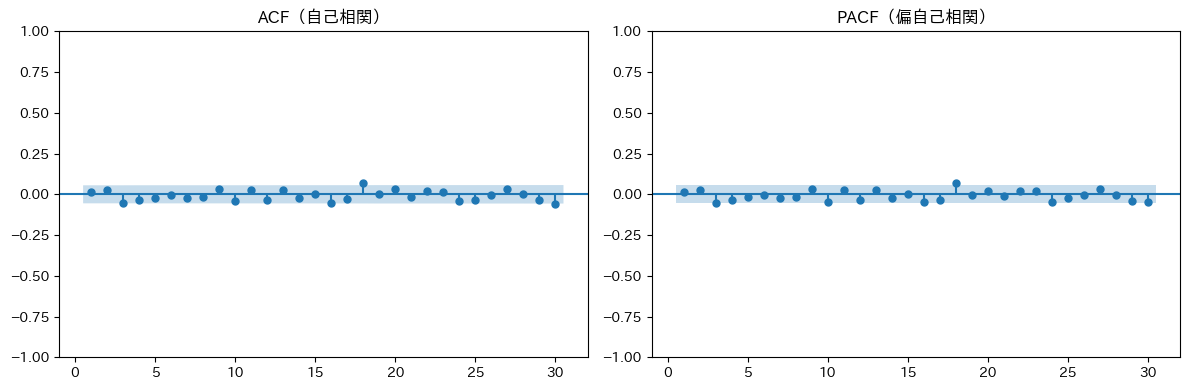

In [ ]:
#%% pとqの決定

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(ts_diff, ax=plt.gca(), lags=range(1, 31))
plt.title("ACF（自己相関）")
plt.subplot(1, 2, 2)
plot_pacf(ts_diff, ax=plt.gca(), lags=range(1, 31), method="ywm")
plt.title("PACF（偏自己相関）")
plt.tight_layout()
plt.show()
# ヒント: PACFもACFもラグ1以降で有意な相関がほとんど見られないため、
#         1階差分で十分に定常化されており、pやqは小さい値（例: p=0, q=0）が妥当かもしれない。
#         （ARIMAモデルのパラメータは、モデルの適合度などを考慮して最終決定します）



 ## 4. モデル構築と予測

 ### 4-1. ARIMAモデルによる予測

 探索的データ分析の結果に基づき、**ARIMA(0,1,0)モデル**を構築する。このモデルは**「ランダムウォーク・モデル」**とも呼ばれ、「明日の価格の最も良い予測値は、今日の価格である」という、極めてシンプルかつ強力なモデルである。

 このモデルに過去4年分のデータを学習させ、直近1年間の株価を予測させる。

 **【予測結果の考察】**
 予測値（赤線）は完全に横ばいになっている。これは、ランダムウォーク・モデルが「未来のランダムな値動きは予測不能であり、期待値としては変化しない（ドリフトなし）」と仮定しているためである。これは、一見すると「何も予測していない」ように見えるが、実は**市場のランダム性を最も正直に反映した予測**と言える。

/Users/kazuu/Desktop/Quant/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kazuu/Desktop/Quant/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kazuu/Desktop/Quant/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kazuu/Desktop/Quant/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an

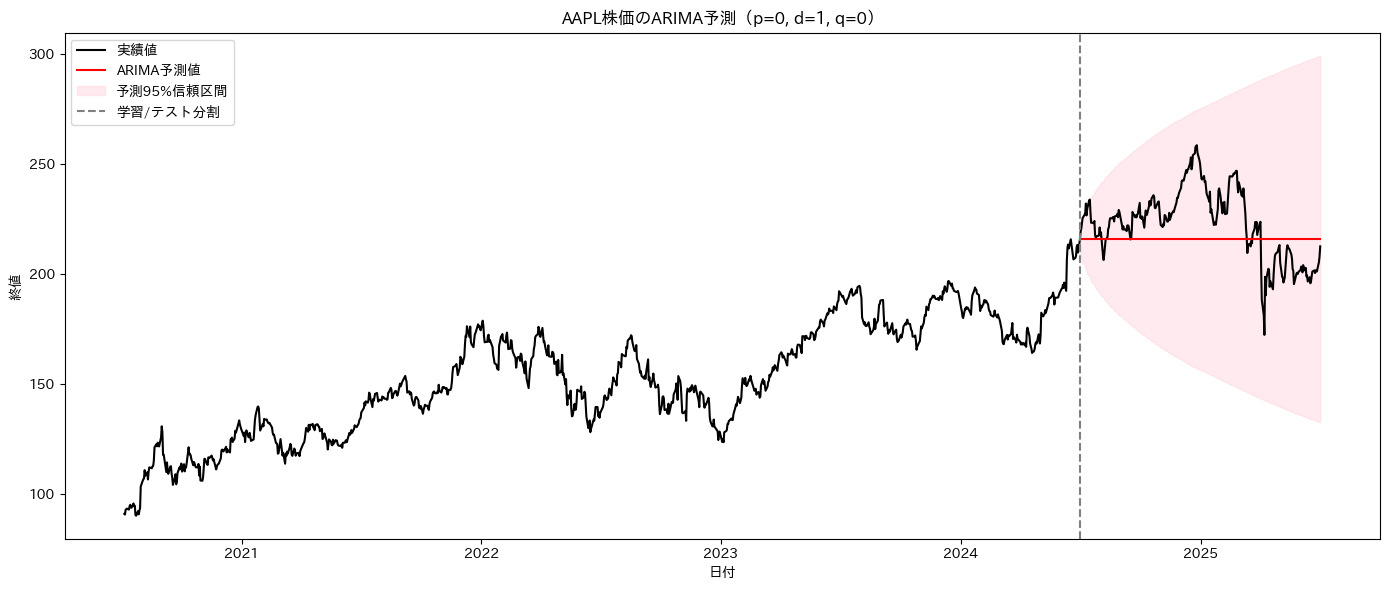

In [ ]:
#%% ARIMAモデルによる予測

# データ分割（過去4年を学習用、直近1年をテスト用）
split_date = ts_data.index[-252]  # おおよそ1年分（営業日252日）
train = ts_data[:split_date]
test = ts_data[split_date:]

# ARIMAパラメータの決定（例: p=0, d=1, q=0）
p, d, q = 0, 1, 0
# 理由: 1階差分で定常化され、ACFもPACFもラグ1以降で有意な相関がほとんど見られないため

# モデル構築と学習
to_fit = train.dropna()  # 欠損値除去
model = ARIMA(to_fit, order=(p, d, q))
model_fit = model.fit()

# テスト期間の予測（start/endを整数で指定）
start = len(train)
end = len(train) + len(test) - 1
pred = model_fit.get_prediction(start=start, end=end)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

# 予測結果のインデックスをテストデータのインデックスに合わせる
pred_mean.index = test.index
pred_ci.index = test.index

# プロット
plt.figure(figsize=(14, 6))
plt.plot(ts_data, label="実績値", color="black")
plt.plot(pred_mean, label="ARIMA予測値", color="red")
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="pink", alpha=0.3, label="予測95%信頼区間")
plt.axvline(split_date, color="gray", linestyle="--", label="学習/テスト分割")
plt.title("AAPL株価のARIMA予測（p=0, d=1, q=0）")
plt.xlabel("日付")
plt.ylabel("終値")
plt.legend()
plt.tight_layout()
plt.show()



 ### 4-2. Prophetモデルによる予測

 次に、全く異なるアプローチを取るProphetモデルで予測を行う。Prophetは、データの内部構造ではなく、**「トレンド」「週単位の季節性」「年単位の季節性」**といったパターンを自動で抽出し、それらを組み合わせて未来を予測する。

 **【予測結果と成分分解の考察】**
 - **予測結果:** Prophetの予測値（青線）は、過去の季節性パターンを未来に延長するように、滑らかな曲線を描いている。これは「過去は繰り返す」という仮定に基づいている。
 - **成分分解:** `plot_components`の結果は、ProphetがAAPL株価に「9月頃にピークを迎える年周期」や「週の半ばに高く、週末にかけて下がる週周期」といった、一見もっともらしいパターンを見出していることを示している。

21:11:28 - cmdstanpy - INFO - Chain [1] start processing
21:11:28 - cmdstanpy - INFO - Chain [1] done processing


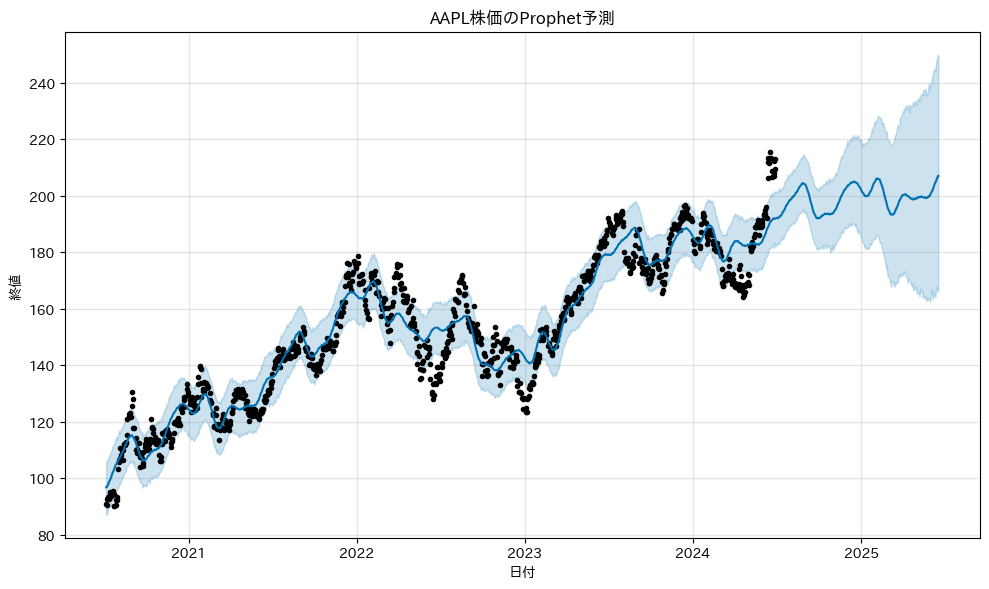

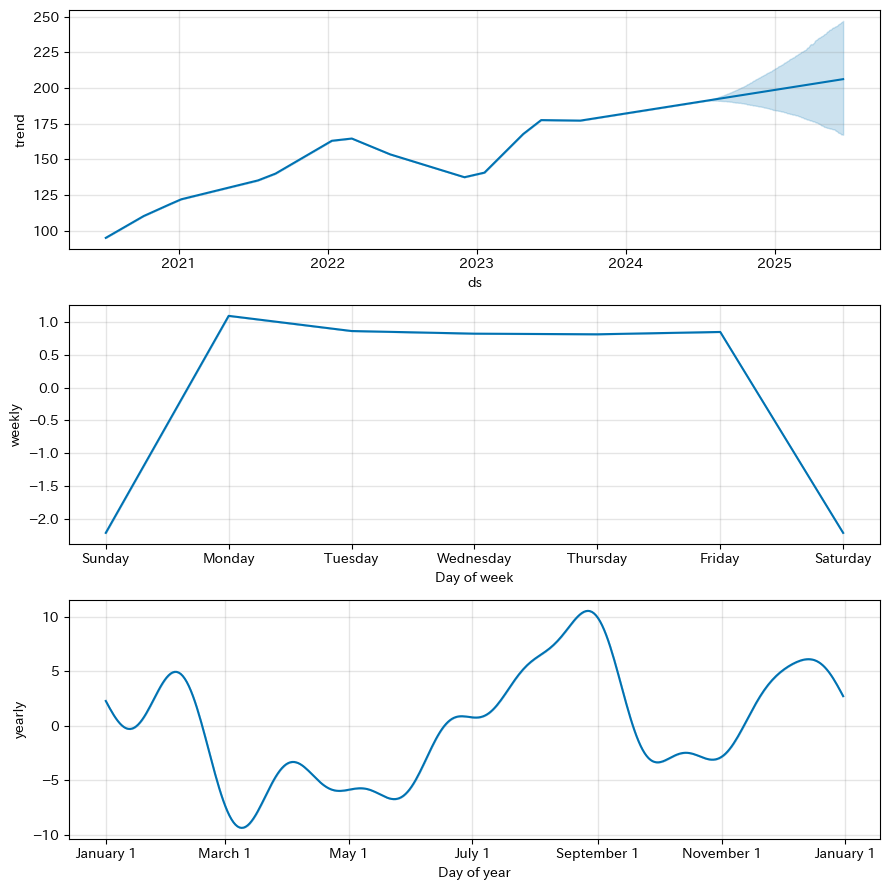

In [ ]:
#%% Prophetモデルによる予測

# Prophet用にカラム名を変換
ts_df = ts_data.reset_index()
ts_df.columns = ['ds', 'y']

# データ分割（過去4年を学習用、直近1年をテスト用）
train_df = ts_df.iloc[:-252]
test_df = ts_df.iloc[-252:]

# Prophetモデルのインスタンス化と学習
to_fit_df = train_df.dropna()
model_prophet = Prophet()
model_prophet.fit(to_fit_df)

# 未来のデータフレーム作成（テスト期間分）
future = model_prophet.make_future_dataframe(periods=len(test_df), freq='B')  # 'B'は営業日
forecast = model_prophet.predict(future)

# 実績値と予測値のプロット
fig1 = model_prophet.plot(forecast)
plt.title("AAPL株価のProphet予測")
plt.xlabel("日付")
plt.ylabel("終値")
plt.tight_layout()
plt.show()

# トレンド・季節性の分解プロット
fig2 = model_prophet.plot_components(forecast)
plt.tight_layout()
plt.show()



 ## 5. モデル精度の客観的評価

 2つのモデルの予測が、どちらがより現実に近かったかを、客観的な数値指標で評価する。
 - **MSE (平均二乗誤差):** 誤差の2乗の平均。大きな誤差をより重視する。
 - **MAE (平均絶対誤差):** 誤差の絶対値の平均。直感的に誤差の大きさを把握しやすい。

 **【評価結果の考察】**
 結果は、**ARIMA(0,1,0)モデルが、Prophetモデルの半分以下の誤差（MSE: 288.96 vs 732.34）しか出しておらず、圧倒的に精度が高い**ことを示した。

 これは、実際の株価の動きが、Prophetが仮定したような「綺麗な季節性の繰り返し」よりも、ARIMAが仮定した**「予測不能なランダムウォーク」**に遥かに近かったことを意味する。過去のパターンに固執したProphetの予測は、結果的にノイズを拾いすぎてしまい、精度を悪化させた。

 この結果は、**「最もシンプルなモデルが、最も良い結果をもたらすことがある（オッカムの剃刀）」**という、科学とデータ分析における重要な教訓を示している。

In [ ]:
#%% モデル精度の評価

from sklearn.metrics import mean_squared_error, mean_absolute_error

# テスト期間の実績値
actual = test.values

# ARIMA予測値
arima_pred = pred_mean.values
arima_mse = mean_squared_error(actual, arima_pred)
arima_mae = mean_absolute_error(actual, arima_pred)

# Prophet予測値（forecastのyhat列からテスト期間分を抽出）
prophet_pred = forecast.iloc[-len(test):]["yhat"].values
prophet_mse = mean_squared_error(actual, prophet_pred)
prophet_mae = mean_absolute_error(actual, prophet_pred)

print("==== モデル精度の評価（テスト期間） ====")
print(f"ARIMAモデル:    MSE={arima_mse:.2f}, MAE={arima_mae:.2f}")
print(f"Prophetモデル:  MSE={prophet_mse:.2f}, MAE={prophet_mae:.2f}")

if arima_mse < prophet_mse:
    print("→ ARIMAモデルの方がMSEが小さく、精度が高いです。")
elif arima_mse > prophet_mse:
    print("→ Prophetモデルの方がMSEが小さく、精度が高いです。")
else:
    print("→ 両モデルのMSEは同じです。")

==== モデル精度の評価（テスト期間） ====
ARIMAモデル:    MSE=288.96, MAE=14.22
Prophetモデル:  MSE=784.27, MAE=24.46
→ ARIMAモデルの方がMSEが小さく、精度が高いです。
